In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords, gutenberg
from nltk.collections import *
from nltk import FreqDist, word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pickle

In [88]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ferityikar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
tw_df = pd.read_csv('data/BTC_tweets_daily_example.csv')

In [90]:
nlp_data = tw_df[['Tweet','Sentiment']]

In [91]:
sent_dict = {"['neutral']": 'Neutral',"['positive']": 'Positive', "['negative']": 'Negative'}
nlp_data.Sentiment = nlp_data.Sentiment.map(sent_dict)

/Users/ferityikar/opt/anaconda3/envs/btc-nlp/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [92]:
nlp_data.groupby('Sentiment').count()

,Tweet
Sentiment,
Negative,5983
Neutral,21932
Positive,22937


In [93]:
nlp_data = nlp_data.dropna()

In [94]:
nlp_data

,Tweet,Sentiment
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",Neutral
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,Neutral
2,RT @tippereconomy: Another use case for #block...,Positive
3,free coins https://t.co/DiuoePJdap,Positive
4,RT @payvxofficial: WE are happy to announce th...,Positive
...,...,...
50868,RT @fixy_app: Fixy Network brings popular cryp...,Positive
50869,RT @bethereumteam: After a successful launch o...,Positive
50870,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",Neutral
50871,I added a video to a @YouTube playlist https:/...,Positive


In [95]:
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

def pattern_apply(input):
    return input.str.replace('[^a-zA-Z]', ' ')

def remove_short(input, length=3):
    return input.apply(lambda x: ' '.join([w for w in x.split() if len(w) > length]))

def tokenize(input):
    return input.apply(lambda x: x.split())

def stemmer(input):
    return input.apply(lambda x: [SnowballStemmer('english').stem(i) for i in x])

def join_tokenize(input):
    return input.apply(lambda x: ' '.join(x))

def hashtag_extract(input, flatten=True):
    hashtags = []
    for i in input:
        ht = re.findall(r"#(\w+)", i)
        if flatten:
            hashtags.append(ht)
        else:
            hashtags.append([ht])

    return sum(hashtags, [])

In [112]:
def cleaning_pipeline(nlp_data):
    nlp_data['TweetClean'] = np.vectorize(remove_pattern)(nlp_data['Tweet'],"@[\w]*")
    nlp_data['TweetClean'] = np.vectorize(remove_pattern)(nlp_data['TweetClean'],'https?://[A-Za-z0-9./]+')
    nlp_data['TweetClean'] = pattern_apply(nlp_data['TweetClean'])
    nlp_data['TweetClean'] = remove_short(nlp_data['TweetClean'])
    tokenized_tweet = tokenize(nlp_data['TweetClean'])
    tokenized_tweet = stemmer(tokenized_tweet)
    nlp_data['TweetClean'] = join_tokenize(tokenized_tweet)
    nlp_data['TweetClean'] = np.vectorize(remove_pattern)(nlp_data['TweetClean'],"#[\w]*")
    nlp_data['Name Length'] = nlp_data['TweetClean'].str.len()

    return nlp_data

In [113]:
nlp_data = cleaning_pipeline(nlp_data)

In [98]:
nlp_data

,Tweet,Sentiment,TweetClean,Name Length
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",Neutral,paul krugman nobel luddit tweak nose this bitc...,88
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,Neutral,said know noth about bitcoin,28
2,RT @tippereconomy: Another use case for #block...,Positive,anoth case blockchain tipper tippereconomi uns...,77
3,free coins https://t.co/DiuoePJdap,Positive,free coin,9
4,RT @payvxofficial: WE are happy to announce th...,Positive,happi announc that payvx presal phase live sig...,62
...,...,...,...,...
50868,RT @fixy_app: Fixy Network brings popular cryp...,Positive,fixi network bring popular cryptocurr retail p...,100
50869,RT @bethereumteam: After a successful launch o...,Positive,after success launch bounti campaign manag fil...,71
50870,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",Neutral,gymreward token bonus time end cryptocurr mobi...,62
50871,I added a video to a @YouTube playlist https:/...,Positive,ad video playlist bitcoin cloud mine free life...,60


In [11]:
nlp_data['Name Length'].sort_values(ascending=False)

24604    112
21877    108
16906    107
20201    106
18387    106
        ... 
45077      0
5144       0
14263      0
14641      0
2537       0
Name: Name Length, Length: 50852, dtype: int64

LSTM MODEL

Train-Test Split

In [184]:
X = nlp_data.TweetClean
enc = OneHotEncoder()
y = enc.fit_transform(np.array(nlp_data['Sentiment']).reshape(-1,1)).toarray()


In [185]:
max_num_words = 50000
max_sequence_len = 112
embedding_dim = 100

tokenizer_lstm = Tokenizer(num_words = max_num_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{\}~', lower=True)
tokenizer_lstm.fit_on_texts(X.values)
word_index = tokenizer_lstm.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 11349 unique tokens.


In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35596,), (15256,), (35596, 3), (15256, 3))

In [187]:
pickle_out = open('charts/tokenizer_lstm.pickle','wb')
pickle.dump(tokenizer_lstm, pickle_out)
pickle_out.close()

In [203]:
X_train = tokenizer_lstm.texts_to_sequences(X_train.values)
X_test = tokenizer_lstm.texts_to_sequences(X_test.values)
X_train = pad_sequences(X_train, maxlen=max_sequence_len)
X_test = pad_sequences(X_test, maxlen=max_sequence_len)


In [204]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35596, 112), (15256, 112), (35596, 3), (15256, 3))

RNN Model

In [190]:
nlp_model = Sequential()
nlp_model.add(Embedding(max_num_words, embedding_dim, input_length=112))
nlp_model.add(SpatialDropout1D(0.2))
nlp_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
nlp_model.add(Dense(3, activation='softmax'))
nlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [191]:
nlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 112, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 112, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________


In [192]:
#Save the best model
filepath = 'models/nlp_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
callbacks = [checkpoint]

In [193]:
nlp_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/5
223/223 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8034
Epoch 00001: val_loss improved from inf to 0.22191, saving model to models/nlp_model.hdf5
223/223 [==============================] - 58s 260ms/step - loss: 0.4732 - accuracy: 0.8034 - val_loss: 0.2219 - val_accuracy: 0.9271
Epoch 2/5
223/223 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9490
Epoch 00002: val_loss improved from 0.22191 to 0.17246, saving model to models/nlp_model.hdf5
223/223 [==============================] - 65s 293ms/step - loss: 0.1603 - accuracy: 0.9490 - val_loss: 0.1725 - val_accuracy: 0.9449
Epoch 3/5
223/223 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9677
Epoch 00003: val_loss did not improve from 0.17246
223/223 [==============================] - 59s 263ms/step - loss: 0.1036 - accuracy: 0.9677 - val_loss: 0.1746 - val_accuracy: 0.9483
Epoch 4/5
223/223 [==============================] - ETA: 0s - loss: 0.0760 - 

In [205]:
load_file = 'models/nlp_model.hdf5'
nlp_model = load_model(load_file)
y_hat = nlp_model.predict(X_test)

In [207]:
y_hat = pd.DataFrame(y_hat, columns=['Negative', 'Neutral', 'Positive'])
y_hat['prediction'] = y_hat.idxmax(1)

y_test_df = pd.DataFrame(y_test, columns=['Negative', 'Neutral', 'Positive'])
y_test_df['Actual'] = y_test_df.idxmax(1)

In [208]:
y_hat

,Negative,Neutral,Positive,prediction
0,0.000107,0.999246,0.000647,Neutral
1,0.000079,0.999596,0.000325,Neutral
2,0.000423,0.998813,0.000765,Neutral
3,0.993099,0.002003,0.004898,Negative
4,0.004421,0.983223,0.012356,Neutral
...,...,...,...,...
15251,0.000093,0.998657,0.001249,Neutral
15252,0.093275,0.885230,0.021495,Neutral
15253,0.000037,0.000422,0.999541,Positive
15254,0.000129,0.999623,0.000248,Neutral


In [210]:
y_test_df

,Negative,Neutral,Positive,Actual
0,0.0,1.0,0.0,Neutral
1,0.0,1.0,0.0,Neutral
2,0.0,1.0,0.0,Neutral
3,1.0,0.0,0.0,Negative
4,0.0,1.0,0.0,Neutral
...,...,...,...,...
15251,0.0,1.0,0.0,Neutral
15252,0.0,0.0,1.0,Positive
15253,0.0,0.0,1.0,Positive
15254,0.0,1.0,0.0,Neutral


In [217]:
y_test_df['Actual'].value_counts()

Positive    6876
Neutral     6557
Negative    1823
Name: Actual, dtype: int64

In [211]:
cm = confusion_matrix(y_test_df['Actual'], y_hat.prediction)

In [212]:
print(cm)

[[1714   55   54]
 [  37 6399  121]
 [  50  141 6685]]


In [214]:
acc = accuracy_score(y_test_df['Actual'], y_hat.prediction)
acc

0.9699790246460409

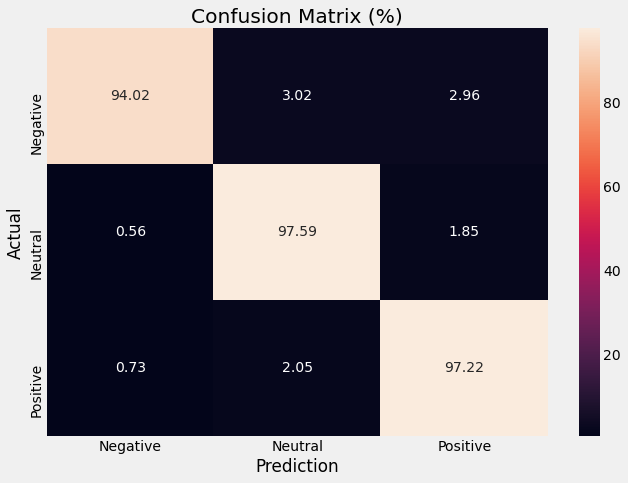

In [222]:
df_cm = pd.DataFrame(cm, index=['Negative','Neutral','Positive'],columns=['Negative','Neutral','Positive'])
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm*100, annot=True, fmt='.2f')
plt.title('Confusion Matrix (%)')
plt.ylabel('Actual')
plt.xlabel('Prediction');